# Overview: Modify Parameterized Ejecta model to analyze the synthetic spectral difference

Whether you are using TARDIS to post-process hydro model outcomes or find a parametrized model to match with observations, understanding how the ejecta model parameter affect the synthetic spectra is important to analyze the physical outcome of your work. 

Let's make some variation of the input ejecta model and explore the spectral difference! 

To make this process more fun, we provide the following files for this notebook:
- SN_Ia.yml: The TARDIS configuration file based on the work from [O'Brien 2021](https://ui.adsabs.harvard.edu/abs/2021ApJ...916L..14O/abstract) on inferencing the observed spectrum of SN2002bo at early time (parameters are modified for the purpose of this notebook).
- A observed spectra file of SN2002bo at early time from [Silverman et al. 2012](https://ui.adsabs.harvard.edu/abs/2012MNRAS.425.1789S/abstract): Intended to be used as an reference spectra when nudging the ejecta model parameter. 

---

For your convenience, the commonly used packages and TARDIS visualization tools are imported in the cell below.

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.ndimage import gaussian_filter1d

from tardis import run_tardis
from tardis.io.configuration.config_reader import Configuration
from tardis.visualization import SDECPlotter, LineInfoWidget, CustomAbundanceWidget
from tardis.visualization.tools.liv_plot import LIVPlotter
from tardis.util.base import atomic_number2element_symbol, int_to_roman
from tardis.workflows.util import get_tau_integ


from astropy import units as u
from astropy import constants as const


# Load the observed spectrum

The original observed spectrum is taken from [WISEReP](https://www.wiserep.org/object/7161), contributed by [Silverman et al. 2012](https://ui.adsabs.harvard.edu/abs/2012MNRAS.425.1789S/abstract). 

Based on [Benetti et al. 2014](https://ui.adsabs.harvard.edu/abs/2004MNRAS.348..261B/abstract), SN2002bo has the following properties:
- Redshift = 0.0043
- Distance (d) = 31.67 Mpc
- UVOIR luminosity at this epoch ~ 2e42 erg/s, with roughly 80% contributing to observed wavelength range of given spectrum.
- Rest frame epoch of -12 days relative to the peak light.

The file is available at `configs_and_data/SN2002bo_2002-03-11_06-14-24_Lick-3m_KAST_BSNIP.dat`.

---

**<span style="background-color: rgba(255, 255, 0, 0.3); padding: 4px;">📝Task</span>**

Assuming the observed spectrum is flux-calibrated, convert the observed flux to luminosity density, so that we can compare with the TARDIS synthetic spectra directly. Use astropy units for this task. Integrate over the converted luminosity density over wavelength to see if the luminosity match with the literature value!

**Physics Background**: 
- Observed flux: $F_{\lambda}$ has unit of [erg $s^{-1}$ $cm^{-2}$ $\lambda^{-1}$]
- Luminosity density: $L_{\lambda}$ has unit of [erg $s^{-1}$ $\lambda^{-1}$]
- Conversion: $L_{\lambda}$ = $F_{\lambda} \times 4\pi d^2$

<details>
<summary><strong>💡 <u>Hint</u> </strong></summary>
The luminosity density should be on the order of 1e38 erg / s / A
</details>


????? say that this process is to shift to be in the same sapce  tardis for comparison xxxxx?????


!!!! amke box to say .values if want to converge padnasddf to astropy its ??????



In [2]:
# your code here
DISTANCE_OBSERVATION = 31.67 * u.Mpc

spec_obs = pd.read_csv(
    "configs_and_data/SN2002bo_2002-03-11_06-14-24_Lick-3m_KAST_BSNIP.dat",
    header=None,
    sep=r"\s+",
    names=["wavelength", "flux"],
)

# spec_obs["luminosity_density"] =

spec_obs.head()

,wavelength,flux
0,3300.0,1.261970e-15
1,3302.0,8.756140e-16
2,3304.0,9.032550e-16
3,3306.0,1.122150e-16
4,3308.0,5.520870e-16


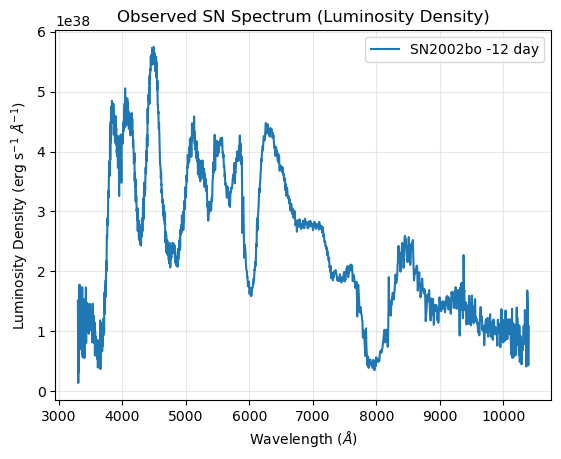

Luminosity density average: 2.38e+38


In [3]:
DISTANCE_OBSERVATION = 31.67 * u.Mpc
REDSHIFT = 0.0043

spec_obs = pd.read_csv(
    "configs_and_data/SN2002bo_2002-03-11_06-14-24_Lick-3m_KAST_BSNIP.dat",
    header=None,
    sep=r"\s+",
    names=["wavelength", "flux"],
)
spec_obs["wavelength"] = spec_obs["wavelength"].values * u.AA
spec_obs["flux"] = spec_obs["flux"].values * u.erg / (u.s * u.cm**2 * u.AA)

# Convert flux density to luminosity density
spec_obs["luminosity_density"] = (
    spec_obs["flux"] / (1 + REDSHIFT) * 4 * np.pi * DISTANCE_OBSERVATION.to(u.cm) ** 2
)

plt.plot(
    spec_obs["wavelength"], spec_obs["luminosity_density"], label="SN2002bo -12 day"
)
plt.xlabel(r"Wavelength ($\AA$)")
plt.ylabel(r"Luminosity Density (erg s$^{-1}$ $\AA^{-1}$)")
plt.title("Observed SN Spectrum (Luminosity Density)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Luminosity density average: {spec_obs['luminosity_density'].mean():.2e}")


# Run the simulation with the unmodified config

In [4]:
# run the simulation with the base configuration
config_base = Configuration.from_yaml("configs_and_data/SN_Ia.yml")
sim_base = run_tardis(
    config_base,
    virtual_packet_logging=True,
    show_convergence_plots=True,
    export_convergence_plots=True,
    log_level="INFO",
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'e4a78ffb-6937-4b72-8ae6-5d5b9776bacf': {'version…

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

    'data': [{'type': 'scatter', 'uid': 'a7187ef0-d1b5-40f1-a373-aeb8387d0dcd', …

    'data': [{'type': 'scatter', 'uid': 'a7187ef0-d1b5-40f1-a373-aeb8387d0dcd', …

# SDEC plot with observed spectra overlay

Make a SDEC plot and overplot the observed spectra on top.

How does the luminosity density of the synthetic spectrum comparing to the observed one? If it's different, how do we nudge the model parameter in TARDIS configuration to match the observation better?

<Axes: xlabel='$\\text{Wavelength}\\,[\\mathrm{\\mathring{A}}]$', ylabel='$L_{\\lambda}\\,[\\mathrm{erg\\,s^{-1}\\,\\mathring{A}^{-1}}]$'>

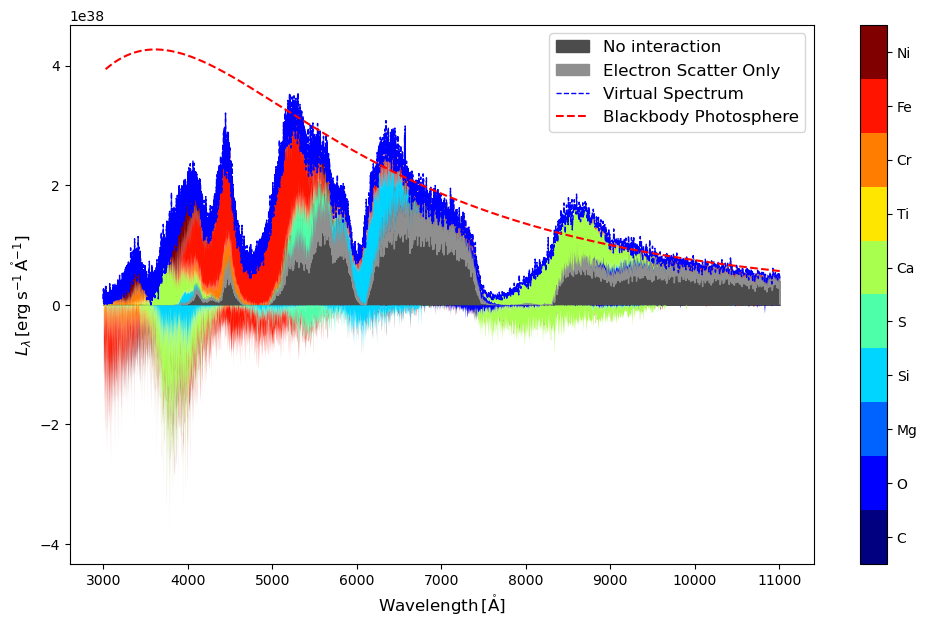

In [5]:
# your code here
plotter = SDECPlotter.from_simulation(sim_base)
plotter.generate_plot_mpl(packets_mode="virtual", packet_wvl_range=[3000, 11000] * u.AA)

## overplot the observed spectrum
# plotter.ax.plot(xxxx)


---
In this notebook, you would plot the comparion of the simulation SDEC plot with the observed spectrum quite many times, to make it more convient, try to make a function to do this, taking in the simulation object and the observed spectrum dataframe as input.



????? use the same foramts as preciou days 

In [6]:
# def plot_SDEC_with_observations(sim, spec_obs, ax=None):
# if ax is None:
#     fig, ax = plt.subplots(figsize=(10, 6))

# # SDEC plot
# plotter = SDECPlotter.from_simulation(sim)
# plotter.generate_plot_mpl(
#     packets_mode="virtual",
#     packet_wvl_range=[3000, 10000] * u.AA,
#     species_list=[
#         "C I-III",
#         "O I-III",
#         "Mg I-III",
#         "S I-III",
#         "Si I-III",
#         "Ca I-III",
#         "Ti I-III",
#         "Fe I-III",
#         "Ar",
#         "Cr",
#         "Ni",
#     ],
#     ax=ax,
# )

# # plot the observed spectrum
# ax.plot(xxxxx)

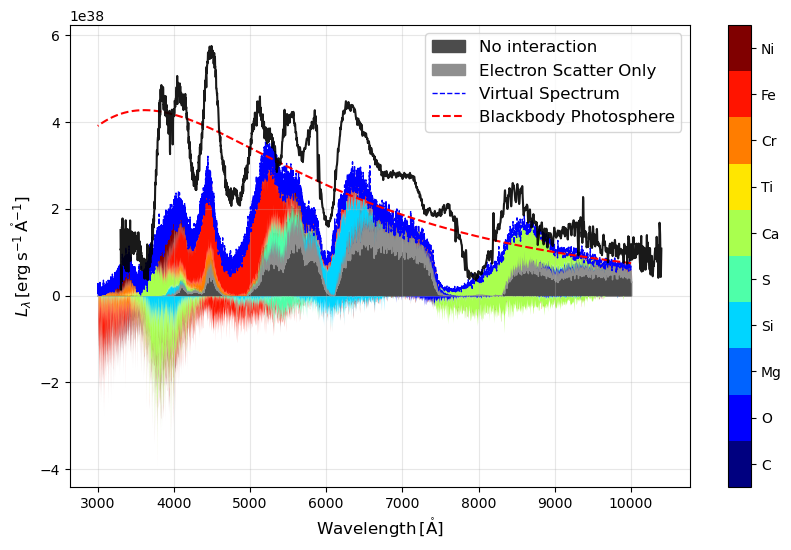

In [7]:
def plot_SDEC_with_observations(sim, spec_obs, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    # SDEC plot
    plotter = SDECPlotter.from_simulation(sim)
    plotter.generate_plot_mpl(
        packets_mode="virtual",
        packet_wvl_range=[3000, 10000] * u.AA,
        # species_list=[
        #     "C I-III",
        #     "O I-III",
        #     "Mg I-III",
        #     "S I-III",
        #     "Si I-III",
        #     "Ca I-III",
        #     "Ti I-III",
        #     "Fe I-III",
        #     "Ar",
        #     "Cr",
        #     "Ni",
        # ],
        ax=ax,
    )

    # plot the observed spectrum
    ax.plot(
        spec_obs["wavelength"],
        spec_obs["luminosity_density"],
        color="k",
        lw=1.5,
        alpha=0.9,
        label="SN2002bo -12 day",
    )
    ax.grid(alpha=0.3)


plot_SDEC_with_observations(sim_base, spec_obs)

# Changing requested luminosity 

You probably noticed that the synthetic spectral luminosity is lower than the observed spectrum and guessed right that we can increase the supernova.requested_luminsoity in the TARDIS config file to nudge it towards higher value. 

For purpose of matching the observed spectra, if we are confident about the bolometric luminosity of the observed spectra, we can directly use that value as the starting point.

Based on [Benetti et al. 2014](https://ui.adsabs.harvard.edu/abs/2004MNRAS.348..261B/abstract), SN2002bo has a UVOIR (UV + Optical + IR) luminosity of ~2e42 erg/s at the time when this spectrum is taken. 

Check the luminosity value used in the config, and then run the simulation again see what happens.

In [8]:
# your code here
print(config_base.supernova)
config_change_L = deepcopy(config_base)

## change the requested luminosity
# config_change_L.supernova.luminosity_requested =

print(config_change_L.supernova)

# sim_change_L = run_tardis(
#     config_change_L,
#     virtual_packet_logging=True,
#     show_convergence_plots=True,
#     export_convergence_plots=True,
#     log_level="INFO",
# )

{'luminosity_requested': <Quantity 1.2e+42 erg / s>, 'time_explosion': <Quantity 8. d>, 'luminosity_wavelength_start': <Quantity 0. Angstrom>, 'luminosity_wavelength_end': <Quantity inf Angstrom>}
{'luminosity_requested': <Quantity 1.2e+42 erg / s>, 'time_explosion': <Quantity 8. d>, 'luminosity_wavelength_start': <Quantity 0. Angstrom>, 'luminosity_wavelength_end': <Quantity inf Angstrom>}


In [9]:
# your code here
print(config_base.supernova)
config_change_L = deepcopy(config_base)

## change the requested luminosity
config_change_L.supernova.luminosity_requested = 2e42 * u.erg / u.s

print(config_change_L.supernova)

sim_change_L = run_tardis(
    config_change_L,
    virtual_packet_logging=True,
    show_convergence_plots=True,
    export_convergence_plots=True,
    log_level="INFO",
)

{'luminosity_requested': <Quantity 1.2e+42 erg / s>, 'time_explosion': <Quantity 8. d>, 'luminosity_wavelength_start': <Quantity 0. Angstrom>, 'luminosity_wavelength_end': <Quantity inf Angstrom>}
{'luminosity_requested': <Quantity 2.e+42 erg / s>, 'time_explosion': <Quantity 8. d>, 'luminosity_wavelength_start': <Quantity 0. Angstrom>, 'luminosity_wavelength_end': <Quantity inf Angstrom>}


BokehModel(combine_events=True, render_bundle={'docs_json': {'f1c59416-171d-49fe-a2f6-8ac51a7738f8': {'version…

TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

    'data': [{'type': 'scatter', 'uid': '724442b1-ecd9-46c8-a4c5-8aaa55ba1d0e', …

    'data': [{'type': 'scatter', 'uid': '724442b1-ecd9-46c8-a4c5-8aaa55ba1d0e', …

**<span style="background-color: rgba(255, 255, 0, 0.3); padding: 4px;">📝Task</span>**

Plot the spectral comparison, does the spectral continuum shape match better with the observed spectrum?

Let's think about what does changing requested luminosity do under the hood of TARDIS? 

1. How does the **radiation field** change with luminosity?

2. How does the **plasma conditions** change with the radiation field?

3. Check **ion contribution** and ionization states, how are they affected?

<details>
<summary><strong>💡 <u>Hint 1</u> </strong></summary>
Higher luminosity means there are more energy escaped from the outer layer, which can be caused by less absorptions along the ejecta and/or higher photospheric temperature. Compare the t_inner (the inner boundary temperature, which defined the initial energy distribution of the packets) and t_radiative (the radiative temperature of each shell) within "sim.simulation_state" class.  
</details>


Similarly, let's make a function for comparing the simulation spectra to be used for future comparison as well. 

In [ ]:
### you code here
# def plot_spectral_comparison(simulations, spec_obs, ax=None, labels=None):
#     if ax is None:
#         fig, ax = plt.subplots(1, 1, figsize=(10, 6))
#     # plot the observed spectrum
#     ax.plot()
#     for sim in simulations:
#         if labels is not None:
#             label = labels[sim]
#         else:
#             luminosity =
#             v_inner =
#             T_inner =
#             label = (
#                 f"L = {luminosity:.2e}, v_inner = {v_inner:.0f}, T_inner = {T_inner:.0f}"
#             )
#         # plot the simulated spectrum, ideally we should be using formal integral but due to time cost
#         # let's use the virtual packets and smooth it
#         sim_wavelength = sim.spectrum_solver.spectrum_virtual_packets.wavelength
#         sim_luminosity_density = gaussian_filter1d(
#             sim.spectrum_solver.spectrum_virtual_packets.luminosity_density_lambda,
#             sigma=3
#         )
#         ax.plot(sim_wavelength, sim_luminosity_density, alpha=0.6, label=label)

#     ax.tick_params(axis="both", labelsize=12)
#     ax.set_xlabel(r"Wavelength ($\AA$)", fontsize=14)
#     ax.set_ylabel(r"Luminosity Density (erg s$^{-1}$ $\AA^{-1}$)", fontsize=14)
#     ax.legend()
#     ax.grid(alpha=0.3)
#     ax.set_xlim(3000, 11000)

# simulations = [sim_base, sim_change_L]
# plot_spectral_comparison(simulations, spec_obs)


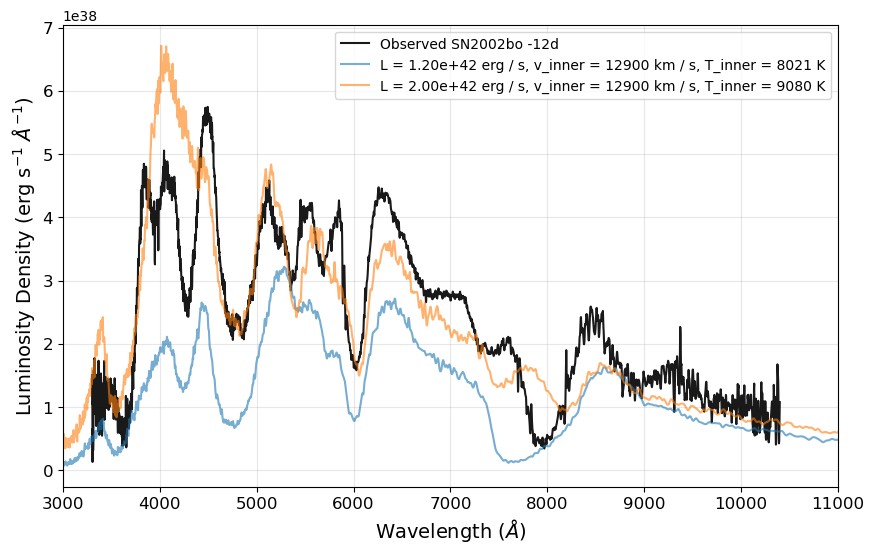

In [55]:
### comparison of spectra
def plot_spectral_comparison(simulations, spec_obs, ax=None, labels=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    # plot the observed spectrum
    ax.plot(
        spec_obs["wavelength"],
        spec_obs["luminosity_density"],
        label="Observed SN2002bo -12d",
        color="black",
        alpha=0.9,
        linewidth=1.5,
    )
    for i, sim in enumerate(simulations):
        if labels is not None:
            label = labels[i]
        else:
            luminosity = sim.luminosity_requested.to(u.erg / u.s)
            v_inner = sim.simulation_state.v_inner[0].to(u.km / u.s)
            T_inner = sim.simulation_state.t_inner.to(u.K)
            label = f"L = {luminosity:.2e}, v_inner = {v_inner:.0f}, T_inner = {T_inner:.0f}"
        sim_wavelength = sim.spectrum_solver.spectrum_virtual_packets.wavelength
        sim_luminosity_density = gaussian_filter1d(
            sim.spectrum_solver.spectrum_virtual_packets.luminosity_density_lambda,
            sigma=3,
        )
        ax.plot(sim_wavelength, sim_luminosity_density, alpha=0.6, label=label)

    ax.tick_params(axis="both", labelsize=12)
    ax.set_xlabel(r"Wavelength ($\AA$)", fontsize=14)
    ax.set_ylabel(r"Luminosity Density (erg s$^{-1}$ $\AA^{-1}$)", fontsize=14)
    ax.legend()
    ax.grid(alpha=0.3)
    ax.set_xlim(3000, 11000)


simulations = [sim_base, sim_change_L]
plot_spectral_comparison(simulations, spec_obs)


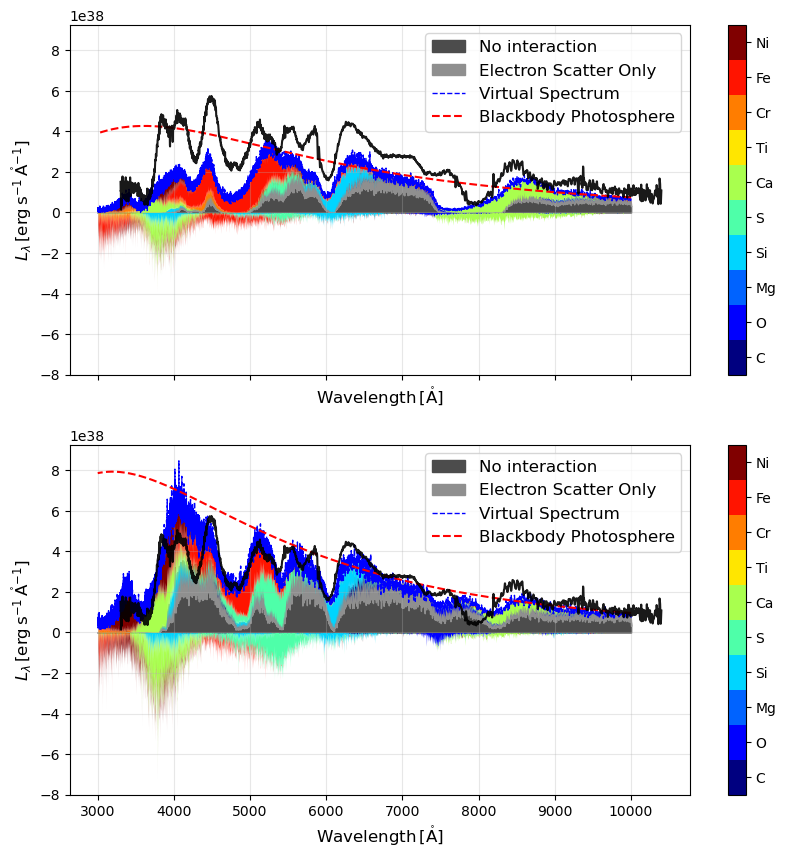

In [14]:
## plot the SDEC plot, match the x and y range for better visual comparison
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True, sharey=True)
plot_SDEC_with_observations(sim_base, spec_obs, ax=axes[0])
plot_SDEC_with_observations(sim_change_L, spec_obs, ax=axes[1])


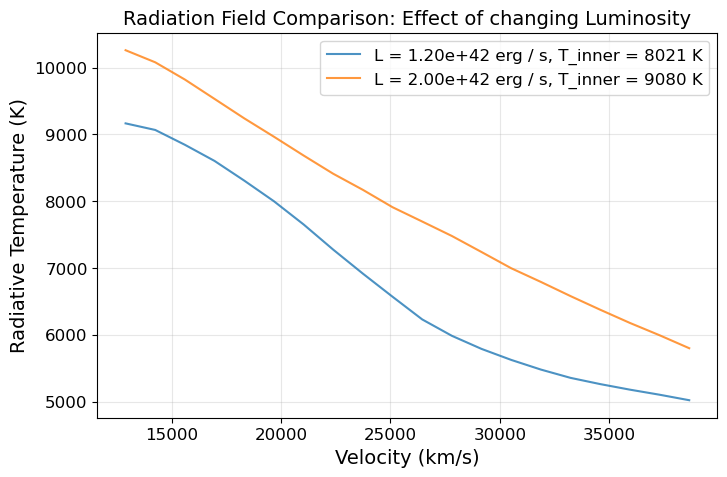

In [15]:
### comparison of the radiation field
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for sim in [sim_base, sim_change_L]:
    label = f"L = {sim.luminosity_requested.to(u.erg / u.s):.2e}, T_inner = {sim.simulation_state.t_inner.to(u.K):.0f}"
    sim_velocity = sim.simulation_state.v_inner.to(u.km / u.s)
    sim_t_radiative = sim.simulation_state.t_radiative.to(u.K)
    ax.plot(sim_velocity, sim_t_radiative, alpha=0.8, label=label)

ax.tick_params(axis="both", labelsize=12)
ax.set_xlabel(r"Velocity (km/s)", fontsize=14)
ax.set_ylabel(r"Radiative Temperature (K)", fontsize=14)
ax.set_title("Radiation Field Comparison: Effect of changing Luminosity", fontsize=14)
ax.legend(fontsize=12)
ax.grid(alpha=0.3)

In [16]:
## plot the LIV plot
# plotter = LIVPlotter.from_simulation(sim_base)
# plotter.generate_plot_mpl(xlog_scale=False, ylog_scale=True)
# plotter_change_L = LIVPlotter.from_simulation(sim_change_L)
# plotter_change_L.generate_plot_mpl(xlog_scale=False, ylog_scale=True)


In [17]:
# see which ions are the dominant contributors to the spectrum
wavelength_range = [7000, 9000]
line_info_widget = LineInfoWidget.from_simulation(sim_base)
display(
    line_info_widget.get_species_interactions(
        wavelength_range=wavelength_range, filter_mode="packet_out_nu"
    )
)

line_info_widget_change_L = LineInfoWidget.from_simulation(sim_change_L)
display(
    line_info_widget_change_L.get_species_interactions(
        wavelength_range=wavelength_range, filter_mode="packet_out_nu"
    )
)


,Fraction of packets interacting
Species,
Ca II,0.711852
O I,0.111171
Ni II,0.075130
Fe II,0.071723
Si II,0.016317
S II,0.008965
Cr II,0.002690
S I,0.000897
C II,0.000717


,Fraction of packets interacting
Species,
Ca II,0.489810
O I,0.222107
Ni II,0.100518
S II,0.083592
Fe II,0.061485
Si II,0.030052
C II,0.008981
Cr II,0.002073
C I,0.000691


# Estimate v_inner_boundary from observation 

Just like what we explored in the morning, the v_inner_boundary is an important setting in TARDIS. If the v_inner_boundary is set at a location far too inward or outward of the photosphere, the synthetical spectrum likely are not physical.

---

**Si II $\lambda$ 6355 as Photospheric Velocity Indicator?**

The Si II $\lambda$ 6355 absorption line is one of the most prominent features in Type Ia supernova spectra and serves as a key diagnostic for measuring photospheric expansion velocities in observational studies. The absorption minimum of this line provides an estimate of the velocity at which the photosphere is expanding.

**Velocity calcualton from absorption minima:**
$$v = c \times \frac{\lambda_{rest} - \lambda_{obs}}{\lambda_{rest}}$$

**Practical Application:**
For simulation purpose, this velocity estimate can serve as an educated guess for the `v_inner` boundary in TARDIS.

**<span style="background-color: rgba(255, 255, 0, 0.3); padding: 4px;">📝Task</span>**

1. **Identify Si II absorption**: Locate the Si II $\lambda$ 6355 absorption minimum wavelength in the observed spectrum
2. **Calculate velocity**: Use the Doppler shift formula to estimate the expansion velocity  
3. **Apply as v_inner**: Use this velocity as a guess for the inner boundary and run the simulation 

---

<details>
<summary><strong>💡 <u>Hint</u> </strong></summary>
The measured Si II velocity shoud be around 15300 km/s. 
</details>

In [18]:
# your code here to measure the observed Si II 6355 velocity

# expansion_velocity_km_s = xxx * u.km/u.s

Observed Si II 6355 absorption minimum: 6030.0 Angstrom
Estimated expansion velocity: 15332 km / s


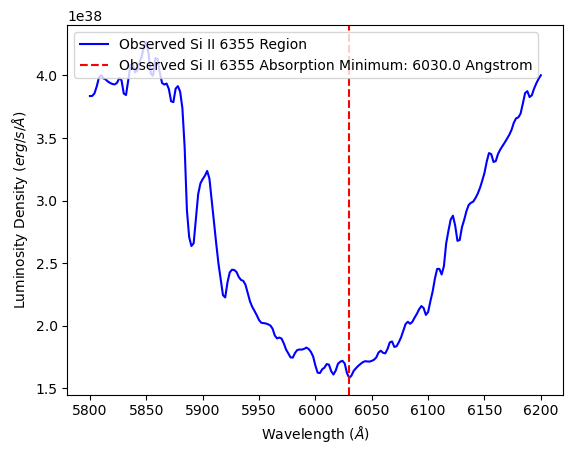

In [35]:
# Estimate v_inner from Si II 6355 absorption minimum
"""
Note that this is just a estimation. In observational studies, 
a more precise method is applied, in which the continuum is 
removed before measure the absorption minima.
"""
SI_II_REST_WAVELENGTH = 6355.0 * u.AA

# Find Si II 6355 absorption minimum in observed spectrum
si_region_mask = (spec_obs["wavelength"].values.value >= 5800) & (
    spec_obs["wavelength"].values.value <= 6200
)
si_region_flux = spec_obs["luminosity_density"][si_region_mask]
si_region_wavelength = spec_obs["wavelength"][si_region_mask]

# Find absorption minimum (lowest flux point)
min_flux_index = np.argmin(si_region_flux)
observed_si_wavelength = si_region_wavelength.iloc[min_flux_index]

plt.plot(si_region_wavelength, si_region_flux, "b-", label="Observed Si II 6355 Region")
plt.axvline(
    observed_si_wavelength.value,
    color="r",
    linestyle="--",
    label=f"Observed Si II 6355 Absorption Minimum: {observed_si_wavelength:.1f}",
)
plt.xlabel(r"Wavelength ($\AA$)")
plt.ylabel(r"Luminosity Density ($erg/s/\AA$)")
plt.legend()

# Calculate expansion velocity from Doppler shift
expansion_velocity = (
    const.c * (SI_II_REST_WAVELENGTH - observed_si_wavelength) / SI_II_REST_WAVELENGTH
)
expansion_velocity_km_s = expansion_velocity.to(u.km / u.s)

print(f"Observed Si II 6355 absorption minimum: {observed_si_wavelength:.1f}")
print(f"Estimated expansion velocity: {expansion_velocity_km_s:.0f}")


In [20]:
# your code here

# print(
#     f"Previous v_inner: {config_change_L.model.structure.velocity.start.to(u.km / u.s):.0f}"
# )
# config_change_v_inner = deepcopy(config_change_L)
# # Apply the physics-based estimate of v_inner
# config_change_v_inner.model.structure.velocity.start = expansion_velocity_km_s
# print(
#     f"New v_inner (from Si II): {config_change_v_inner.model.structure.velocity.start.to(u.km / u.s):.0f}"
# )

# sim_change_v_inner = run_tardis(
#     config_change_v_inner,
#     virtual_packet_logging=True,
#     show_convergence_plots=False,
#     export_convergence_plots=False,
#     log_level="INFO",
# )


In [21]:
print(
    f"Previous v_inner: {config_change_L.model.structure.velocity.start.to(u.km / u.s):.0f}"
)
config_change_v_inner = deepcopy(config_change_L)
# Apply the physics-based estimate of v_inner
config_change_v_inner.model.structure.velocity.start = expansion_velocity_km_s
print(
    f"New v_inner (from Si II): {config_change_v_inner.model.structure.velocity.start.to(u.km / u.s):.0f}"
)

sim_change_v_inner = run_tardis(
    config_change_v_inner,
    virtual_packet_logging=True,
    show_convergence_plots=False,
    export_convergence_plots=False,
    log_level="INFO",
)


Previous v_inner: 12900 km / s
New v_inner (from Si II): 15332 km / s


BokehModel(combine_events=True, render_bundle={'docs_json': {'074e1b17-60cf-48fc-a5ef-b283795aa1c3': {'version…

TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

**<span style="background-color: rgba(255, 255, 0, 0.3); padding: 4px;">📝Task</span>**

**Compare results**: See how this observation-inferred estimation compares to previous choices of v_inner run.

How does the dilution factors changes? Does the starting shell reach dilution factor of 0.5?  

How does the spectrum different from each other and from the observed spectrum?


In [22]:
# your code here

# def plot_dilution_factor(simulations, ax=None, labels=None):
#     for i, sim in enumerate(simulations):
#         velocity =
#         W =
#         if labels is not None:
#             label = labels[sim]
#         else:
#             luminosity = sim.results["luminosity"]
#             v_inner = sim.results["v_inner"]
#             T_inner = sim.results["T_inner"]
#             label = f"L = {lum:.2e} erg/s, v_inner = {v_inner:.0f}, T_inner = {T_inner:.0f}"
#         ax.plot(
#             velocity,
#             W,
#             alpha=0.8,
#             label=label,
#         )

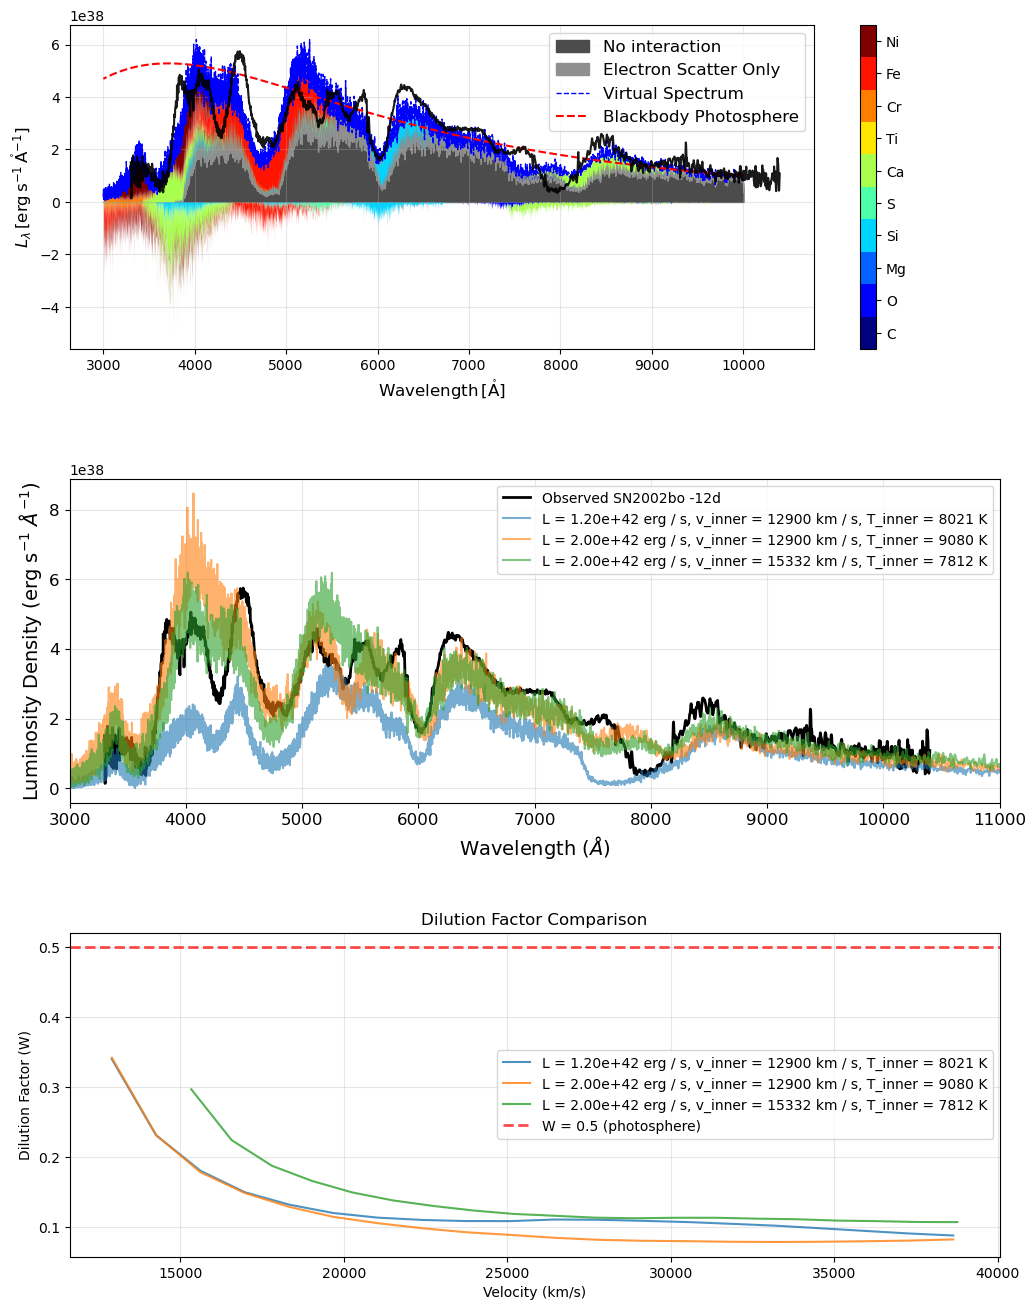

In [23]:
def plot_dilution_factor(simulations, ax=None, labels=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    for i, sim in enumerate(simulations):
        velocity = sim.simulation_state.v_inner.to(u.km / u.s)
        W = sim.simulation_state.dilution_factor
        if labels is not None:
            label = labels[i]
        else:
            # Use the requested luminosity, v_inner, and T_inner from the simulation state
            lum = sim.luminosity_requested.to(u.erg / u.s)
            v_inner = sim.simulation_state.geometry.v_inner[0].to(u.km / u.s)
            T_inner = sim.simulation_state.t_inner.to(u.K)
            label = f"L = {lum:.2e}, v_inner = {v_inner:.0f}, T_inner = {T_inner:.0f}"
        ax.plot(
            velocity,
            W,
            alpha=0.8,
            label=label,
        )
    ax.axhline(
        y=0.5,
        color="red",
        linestyle="--",
        linewidth=2,
        alpha=0.7,
        label="W = 0.5 (photosphere)",
    )
    ax.set_xlabel("Velocity (km/s)")
    ax.set_ylabel("Dilution Factor (W)")
    ax.set_title("Dilution Factor Comparison")
    ax.legend()
    ax.grid(alpha=0.3)


fig, axes = plt.subplots(3, 1, figsize=(12, 16))
plt.subplots_adjust(hspace=0.4)

# plot SDEC with the new v_inner
plot_SDEC_with_observations(sim_change_v_inner, spec_obs, ax=axes[0])

sim_s = [sim_base, sim_change_L, sim_change_v_inner]
# compare the spectra with all previous simulations
plot_spectral_comparison(sim_s, spec_obs, ax=axes[1])

# plot the optical depth current simulation and the one the base config(see the notebook in the morning)
plot_dilution_factor(sim_s, ax=axes[2])



---

Before we move on, let's assess the current spectral match:
- Are the absorption line positions of Si II matching the observed spectrum?  
- How about spectral line profiles of other ions? (Such as S II, Ca II)
- Which feature has a the biggest discrepancy between the synthetic and observed spectra?

**what's next?**: Let's hold v_inner constant for now and systematically explore how other parameters (density, abundance) affect the spectrum before making further adjustments to v_inner.

---

**Key Insight: Parameterized vs. Hydro Models**

Unlike the post-processing workflow with hydro models, parameterized models offer more flexibility but also more complexity:

- **Multiple free parameters**: Luminosity, v_inner, density profile, elemental mass fractions can all be adjusted, It's not constrained by a specific model structure
- **Parameter degeneracies**: Different combinations of parameters can produce similar spectral features.

**Observation provide ejecta properties estimation**

Although the number of free parameter is quite large when exploring these parametrized model, luckily the observational data that we are trying to match with can narrow down some of the parameter range! 

Just like how we estimated the photospheric velocity using the Si II absorption feature in the above part, **is there other photospheric information we can interpret from the observations?**

---

<details>
<summary><strong>💡 <u>Hint</u> </strong></summary>
From the observations of photometric colors and the spectral ionization ratios (such as Fe II vs Fe III), we can estimate the photospheric temperature. 
<a href="https://ui.adsabs.harvard.edu/abs/2004MNRAS.348..261B/abstract">Benetti et al. 2014</a> estimate the photospheric temperature of SN2002bo at early time is on the order of 9500 K. Check what is the the T_inner (sim_change_v_inner.simulation_state.t_inner) of the TARDIS simulation you ran above and think from first principle, what can increase or decrease the T_inner? What parameters we can tune in the eject model? 
</details>


In [24]:
# your code here to diagnose the simulation_state

In [25]:
# check T_inner, this is not really the photospheric temperature, the T_inner in TARDIS should be slightly higher than the effective photospheric temperature
sim_change_v_inner.simulation_state.t_inner

<Quantity 7811.50817384 K>

# How to create photospheric condition? 

By checking the inner temperature ($T_{inner}$) of the above simulation, it is lower than the value inferred from [Benetti et al. 2014](https://ui.adsabs.harvard.edu/abs/2004MNRAS.348..261B/abstract) (~9500 K). 

Assuming we would like to keep the measured Si II 6355 absorption velocity as the v_inner_boundary in TARDIS, what other parameters we can adjust to increase the the dilution factor at this velocity and why? 

**Information Recall**
Recall from day 1 and 3, dilution factor describes the ratio of the energy in a shell relative to the energy emitted by the photosphere. Ideally the first shell should have a dilution factor of 0.5, which means it contains 50% of the energy emitted from the photosphere. This is a similar concept of optical depth $\tau = 2/3$, which corresponding to 50% of the photons can freely escape at that location. 

And based on the radiative transfer equation that follows:

$$I = I_0 e^{-n \sigma l}$$

where:
- $I$ = emergent intensity
- $I_0$ = initial intensity  
- $n$ = number density of absorbing particles
- $\sigma$ = interaction cross-section
- $l$ = path length

**What parameters in the ejecta model can we modify to increase the optical depth (and thus the dilution factor)**

---

<details>
<summary><strong>💡 <u>Hint</u> </strong></summary>
Increasing the number density of the ions would increase the optical depth. If it's a specific set of the ions that you would like to have larger opacity (stronger feature), you can increase the mass fraction of that element. If it's the continuum opacity you would like to increase, then scale up the density profile will increase the optical depth as a whole.  
</details>


<details>
<summary><strong>📝 <u>TASK 0</u> </strong></summary>
Let's increase the density with the goal to drive up the dilution factor at the v_inner_boudary to be around 0.5! Under the assumption of the power law density, which parameter(s) you can adjust in order to increase the density for a specific TARDIS simulation? 

If you can identify more than one parameter to vary, change one at a time while keep the other one same to see their effect. 

! WARNING ! Make sure the dilution factors are within [0,1] otherwise the TARDIS simulation will not be physical. 
</details>

In [26]:
# your code here to run another simulation with modified model parameter

# print(config_change_v_inner.xxx)
# config_change_xxx = deepcopy(config_change_v_inner)
# print(f"New xxx: {config_change_xxx.xxx}")

# sim_change_xxxx = run_tardis(
#     config_change_xxx,
#     virtual_packet_logging=True,
#     show_convergence_plots=False,
#     export_convergence_plots=False,
#     log_level="INFO",
# )

## Exploring Density profile

Congratulations if you tried out parameters that can increase the density of the ejecta, our thoughts are converging! 

If you tried other parameters that are able to increase the dilution faction in the first shell, do let the instructors know and we all will be happy to discuss more! 

The number density of the matter is strongly controlled by the density structure, which then affect the optical depth and the photosphere location. 

**<span style="background-color: rgba(255, 255, 0, 0.3); padding: 4px;">📝Task 1</span>**

<u>**Figure out how many free parameters there are to determine a unique density profile**</u>

**Assumption**: 

The parameters that can affect the density profile under a powerlaw assumption are: 
- t: config.supernova.time_explosion
- $\rho_0$: config.model.structure.density.rho_0
- $t_0$: config.model.structure.density.time_0
- $v_0$ config.model.structure.density.v_0 
- $\alpha$: config.model.structure.density.exponent

For powerlaw density: $\rho(v) = \rho_0 (v/v_0)^{\alpha}$, and for homologous expansion: $\rho(t) = \rho (t_0/t)^3$, hence we have:

$$\rho(v) = \rho_0 (v/v_0)^{\alpha} (t_0/t)^{3}$$

---

**<span style="background-color: rgba(255, 255, 0, 0.3); padding: 4px;">📝Task 2</span>**

Run two simulation that one decrease time_explosion down to 5, another one increase the initial density $\rho_0$, scale the value accordingly so the density in velocity space to be the same. 

Copy the config from `config_change_v_inner`, and run  `sim_change_time_explosion` and `sim_change_rho_0`.


In [ ]:
# your code here to run simulations

In [ ]:
# your code here to plot spectra comparison

In [28]:
### run two simulation with one change time one change initial density

# change time explosion
config_change_time_explosion = deepcopy(config_change_v_inner)
config_change_time_explosion.time_explosion = 5 * u.day

sim_change_time_explosion = run_tardis(
    config_change_time_explosion,
    virtual_packet_logging=True,
    show_convergence_plots=False,
    export_convergence_plots=False,
    log_level="INFO",
)

# change rho_0
config_change_rho_0 = deepcopy(config_change_v_inner)
config_change_rho_0.model.structure.density.rho_0 = (8 / 5) ** 3 * 1e-11 * u.g / u.cm**3

sim_change_rho_0 = run_tardis(
    config_change_rho_0,
    virtual_packet_logging=True,
    show_convergence_plots=False,
    export_convergence_plots=False,
    log_level="INFO",
)


BokehModel(combine_events=True, render_bundle={'docs_json': {'0bbc7228-0697-4dcb-ae96-6d778a58657f': {'version…

TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

BokehModel(combine_events=True, render_bundle={'docs_json': {'cb61890b-2bdc-465f-881e-745c4c76b107': {'version…

TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

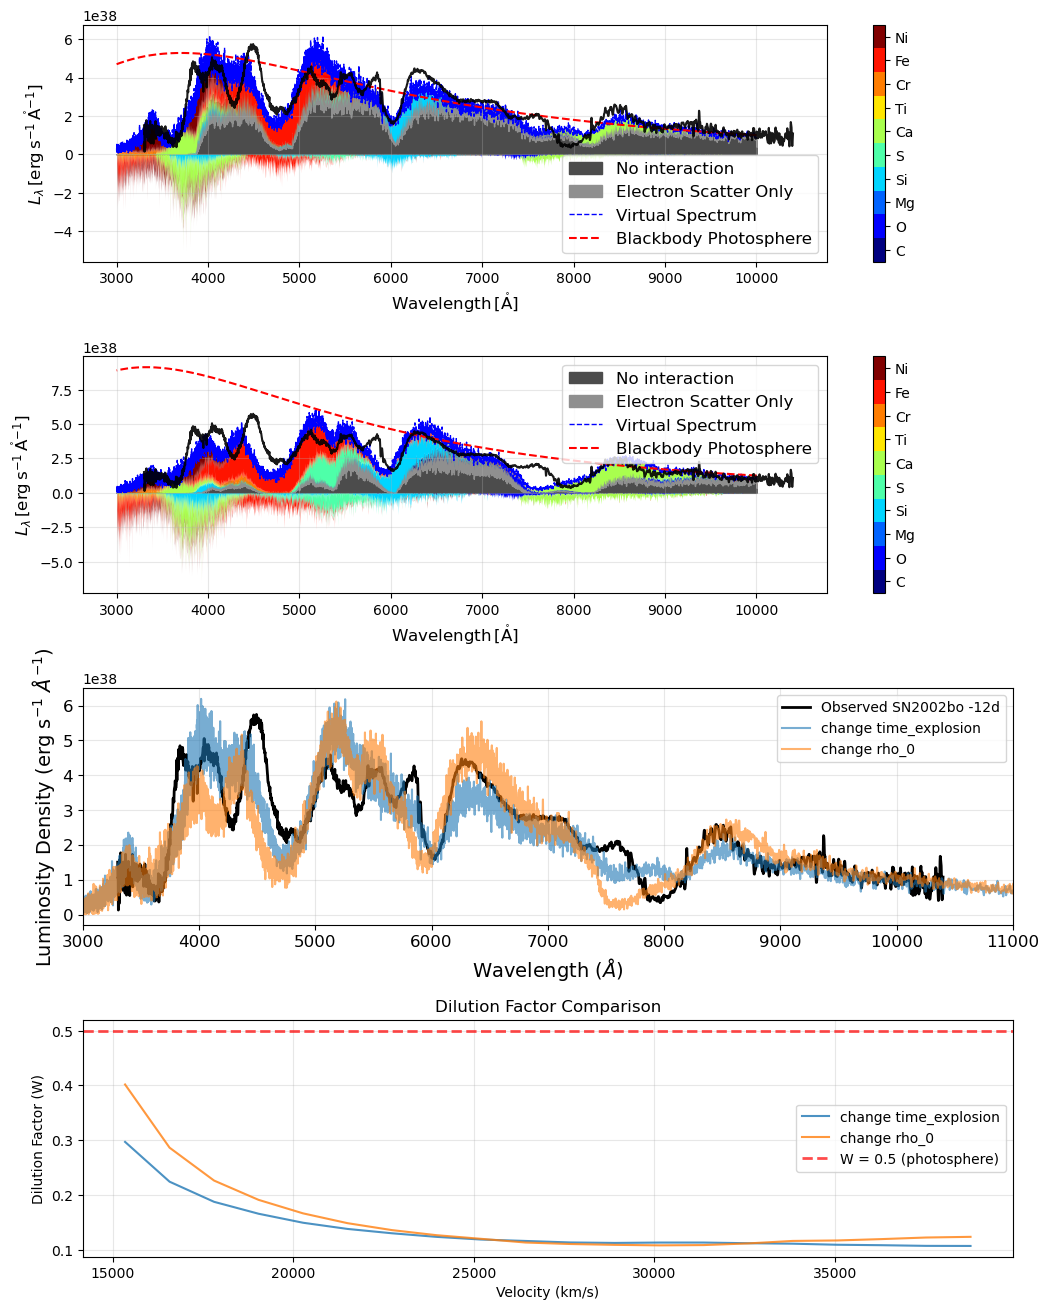

In [32]:
fig, axes = plt.subplots(4, 1, figsize=(12, 16))
plt.subplots_adjust(hspace=0.4)

# plot SDEC
plot_SDEC_with_observations(sim_change_time_explosion, spec_obs, ax=axes[0])
plot_SDEC_with_observations(sim_change_rho_0, spec_obs, ax=axes[1])

sim_s = [sim_change_time_explosion, sim_change_rho_0]
labels = ["change time_explosion", "change rho_0"]
# compare the spectra with previous simulations
plot_spectral_comparison(sim_s, spec_obs, ax=axes[2], labels=labels)

# plot the optical depth current simulation and the one the base config(see the notebook in the morning)
plot_dilution_factor(sim_s, ax=axes[3], labels=labels)


That is a very different outcome even though two of these simulation has the "same" density profile (and abundance too)

Link what you learnt on Day 2 about plasma, how does time affect the plasma state in SN ejecta? 

Since the ejecta expand with time, even though the density profile is the same in terms of expansion velocity, it is NOT in terms of radius. 

Recall from the plasma intro notebook on Day 2, under LTE and homologous expansion assumptions, the optical depth **dimensionless terms** is 
$$
\tau = n_l \cdot \sigma \cdot \frac{1}{dv/dr}
$$
where $dv/dr$ is the time since explosion in our ejecta model.

## Change initial density

Now let's come back to the question and goal of this section (create photospheric condition) again. The question we were trying to get to was:

**How many free parameters there are to determine a unique density profile?**

From the above test cases, we know that the time since explosion $t$ should be treated as an independent parameter when determining the density profile. Although in velocity space, it sometimes can produce the "same" density by adjust both t and $rho_0$, it fundamentally changes the density profile (eg, in radius) and the matter state. 

What about the rest of parameters? We usually can fix the density $v_0$ and $t_0$ as a static reference point, so that the free parameter to determine a unique density structure in a SN ejecta under the assumption of power law are:
- $rho_0$: initial density at the reference point 
- $\alpha$: the power law exponent

---
**<span style="background-color: rgba(255, 255, 0, 0.3); padding: 4px;">📝Task 3</span>**

Following the control variable principle, let's try change the $rho_0$ to increase the density, so that to nudge up the dilution factor to be around 0.5 in order to create a photospheric condition. 

Monitor the dilution factor for the simulations that you tries. 

In [ ]:
# # Modify initial density to increase optical depth
# RHO_0_NEW = xxx * u.g / u.cm**3

# config_change_rho_0_iter_2 = deepcopy(config_change_v_inner)
# config_change_rho_0_iter_2.model.structure.density.rho_0 = RHO_0_NEW

# print(f"Original rho_0: {config_change_v_inner.model.structure.density.rho_0}")
# print(f"New rho_0: {RHO_0_NEW}")

# sim_change_rho_0_iter_2 = run_tardis(
#     config_change_rho_0_iter_2,
#     virtual_packet_logging=True,
#     show_convergence_plots=False,
#     export_convergence_plots=False,
#     log_level="INFO",
# )


In [ ]:
# sim_s = [sim_change_v_inner, sim_change_rho_0, sim_change_rho_0_iter_2]
# labels = ["match v_inner", "change rho_0", "change rho_0_iter_2"]
# # compare the spectra with previous simulations
# plot_spectral_comparison(sim_s, spec_obs, labels=labels)

# # plot the optical depth current simulation and the one the base config(see the notebook in the morning)
# plot_dilution_factor(sim_s, labels=labels)


In [33]:
# Modify initial density to increase optical depth
RHO_0_NEW = 9e-11 * u.g / u.cm**3

config_change_rho_0_iter_2 = deepcopy(config_change_v_inner)
config_change_rho_0_iter_2.model.structure.density.rho_0 = RHO_0_NEW

print(f"Original rho_0: {config_change_v_inner.model.structure.density.rho_0}")
print(f"New rho_0: {RHO_0_NEW}")

sim_change_rho_0_iter_2 = run_tardis(
    config_change_rho_0_iter_2,
    virtual_packet_logging=True,
    show_convergence_plots=False,
    export_convergence_plots=False,
    log_level="INFO",
)


Original rho_0: 1e-11 g / cm3
New rho_0: 9e-11 g / cm3


BokehModel(combine_events=True, render_bundle={'docs_json': {'daef6769-fc19-4f3f-af51-4a4d7d917a0c': {'version…

TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

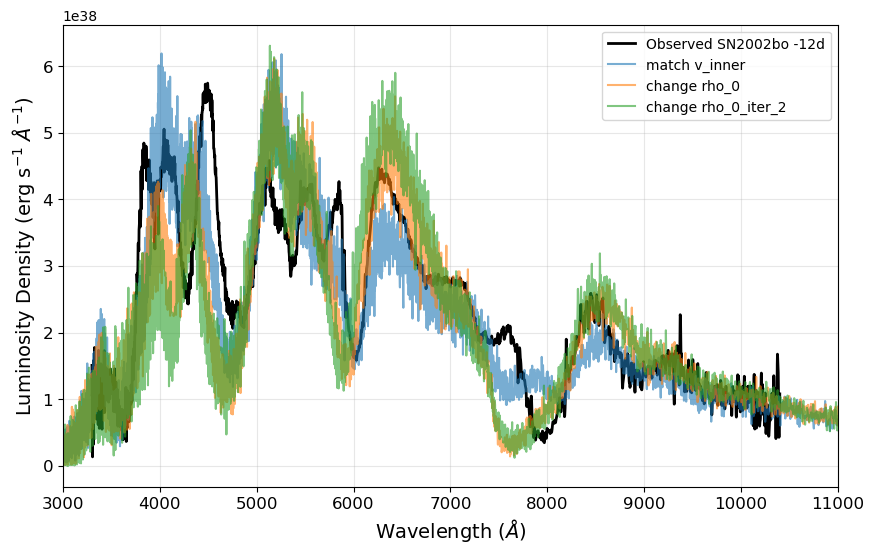

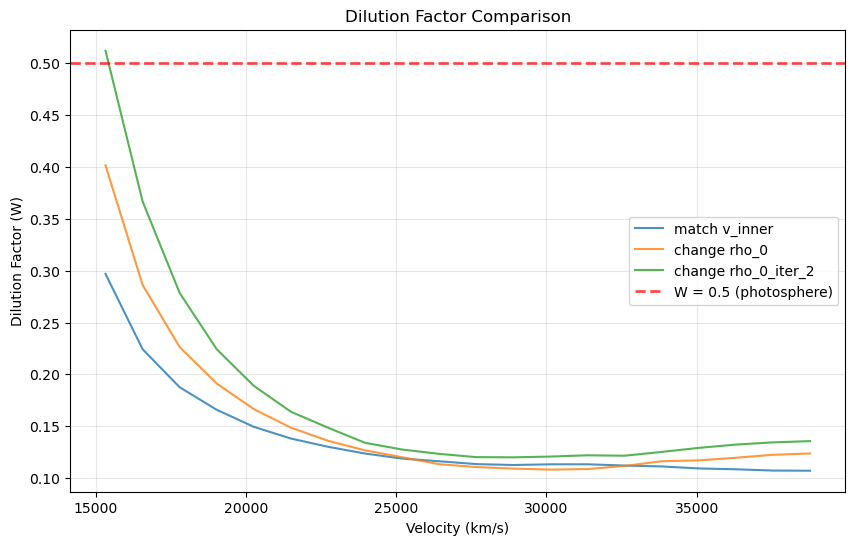

In [34]:
sim_s = [sim_change_v_inner, sim_change_rho_0, sim_change_rho_0_iter_2]
labels = ["match v_inner", "change rho_0", "change rho_0_iter_2"]
# compare the spectra with previous simulations
plot_spectral_comparison(sim_s, spec_obs, labels=labels)

# plot the optical depth current simulation and the one the base config(see the notebook in the morning)
plot_dilution_factor(sim_s, labels=labels)


# Estimate v_outer_boundary from observation 

Using a $\rho_0$ value near 9e-11 $g/cm^3$ is able to create a photospheric condition that the dilution factor is 0.5 in the first shell. How does the simulated spectra compare to the observations? 

Something you might notice is that the absorption velocity of the features are systematically higher than observation even though we set the photosphere velocity to be the same as the absorption velocity of Si II 6355 $\AA$. 

**Similat to how we can estimate the photospheric velocity, we can also estimate the velocity outer boundary of the line formation region from observation**, by measuring the blue-wing velocity of the Si II 6355 $\AA$.

The blue wing velocity is the the velocity is calculated from the wavelength of the edge of the line profile towards the bluer wavelenth edge. 

---

**<span style="background-color: rgba(255, 255, 0, 0.3); padding: 4px;">📝Task</span>**

1. **Identify Si II absorption**: Locate the Si II $\lambda$ 6355 blue wing wavelength in the observed spectrum
2. **Calculate velocity**: Use the Doppler shift formula to estimate the blue-wing velocity  
3. **Apply as v_inner**: Use this velocity as a guess for the velocity outer boundary and run the simulation 

---

<details>
<summary><strong>💡 <u>Hint</u> </strong></summary>
The measured Si II blue-velocity is around 24000 km/s. 
</details>

In [ ]:
# your code of measuring blue-wing velocity here

In [40]:
# blue_wing_velocity_km_s =

# config_change_v_outer = deepcopy(config_change_rho_0_iter_xxx)
# config_change_v_outer.model.structure.velocity.stop = (
#     blue_wing_velocity_km_s * u.km / u.s
# )  # default 40 * u.km / u.s
# print(config_change_v_outer.model.structure.density)

# sim_change_v_outer = run_tardis(
#     config_change_v_outer,
#     virtual_packet_logging=True,
#     show_convergence_plots=True,
#     export_convergence_plots=True,
#     log_level="INFO",
# )


In [ ]:
# your code to compare the spectra with previous simulations here

Observed Si II 6355 blue-wing wavelength: 5850.0 Angstrom
Estimated blue-wing velocity: 23823 km / s


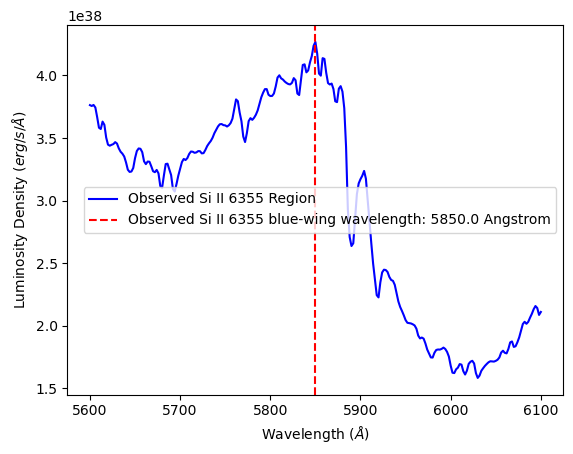

In [37]:
SI_II_REST_WAVELENGTH = 6355.0 * u.AA

# Find Si II blue wing in observed spectrum
si_region_mask = (spec_obs["wavelength"].values.value >= 5600) & (
    spec_obs["wavelength"].values.value <= 6100
)
si_region_flux = spec_obs["luminosity_density"][si_region_mask]
si_region_wavelength = spec_obs["wavelength"][si_region_mask]

# Find absorption minimum (lowest flux point)
min_flux_index = np.argmax(si_region_flux)
observed_si_wavelength = si_region_wavelength.iloc[min_flux_index]

plt.plot(si_region_wavelength, si_region_flux, "b-", label="Observed Si II 6355 Region")
plt.axvline(
    observed_si_wavelength.value,
    color="r",
    linestyle="--",
    label=f"Observed Si II 6355 blue-wing wavelength: {observed_si_wavelength:.1f}",
)
plt.xlabel(r"Wavelength ($\AA$)")
plt.ylabel(r"Luminosity Density ($erg/s/\AA$)")
plt.legend()

# Calculate expansion velocity from Doppler shift
blue_wing_velocity = (
    const.c * (SI_II_REST_WAVELENGTH - observed_si_wavelength) / SI_II_REST_WAVELENGTH
)
blue_wing_velocity_km_s = blue_wing_velocity.to(u.km / u.s)

print(f"Observed Si II 6355 blue-wing wavelength: {observed_si_wavelength:.1f}")
print(f"Estimated blue-wing velocity: {blue_wing_velocity_km_s:.0f}")


In [38]:
config_change_v_outer = deepcopy(config_change_rho_0_iter_2)
config_change_v_outer.model.structure.velocity.stop = (
    24000 * u.km / u.s
)  # default 40 * u.km / u.s
print(config_change_v_outer.model.structure.density)

sim_change_v_outer = run_tardis(
    config_change_v_outer,
    virtual_packet_logging=True,
    show_convergence_plots=True,
    export_convergence_plots=True,
    log_level="INFO",
)


{'type': 'power_law', 'rho_0': <Quantity 9.e-11 g / cm3>, 'time_0': <Quantity 5. d>, 'v_0': <Quantity 8000. km / s>, 'exponent': -7}


BokehModel(combine_events=True, render_bundle={'docs_json': {'3a17f282-7859-454b-b51b-4f46038a567f': {'version…

TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

    'data': [{'type': 'scatter', 'uid': 'f284b8ba-77d5-49b3-85af-3601b286af4f', …

    'data': [{'type': 'scatter', 'uid': 'f284b8ba-77d5-49b3-85af-3601b286af4f', …

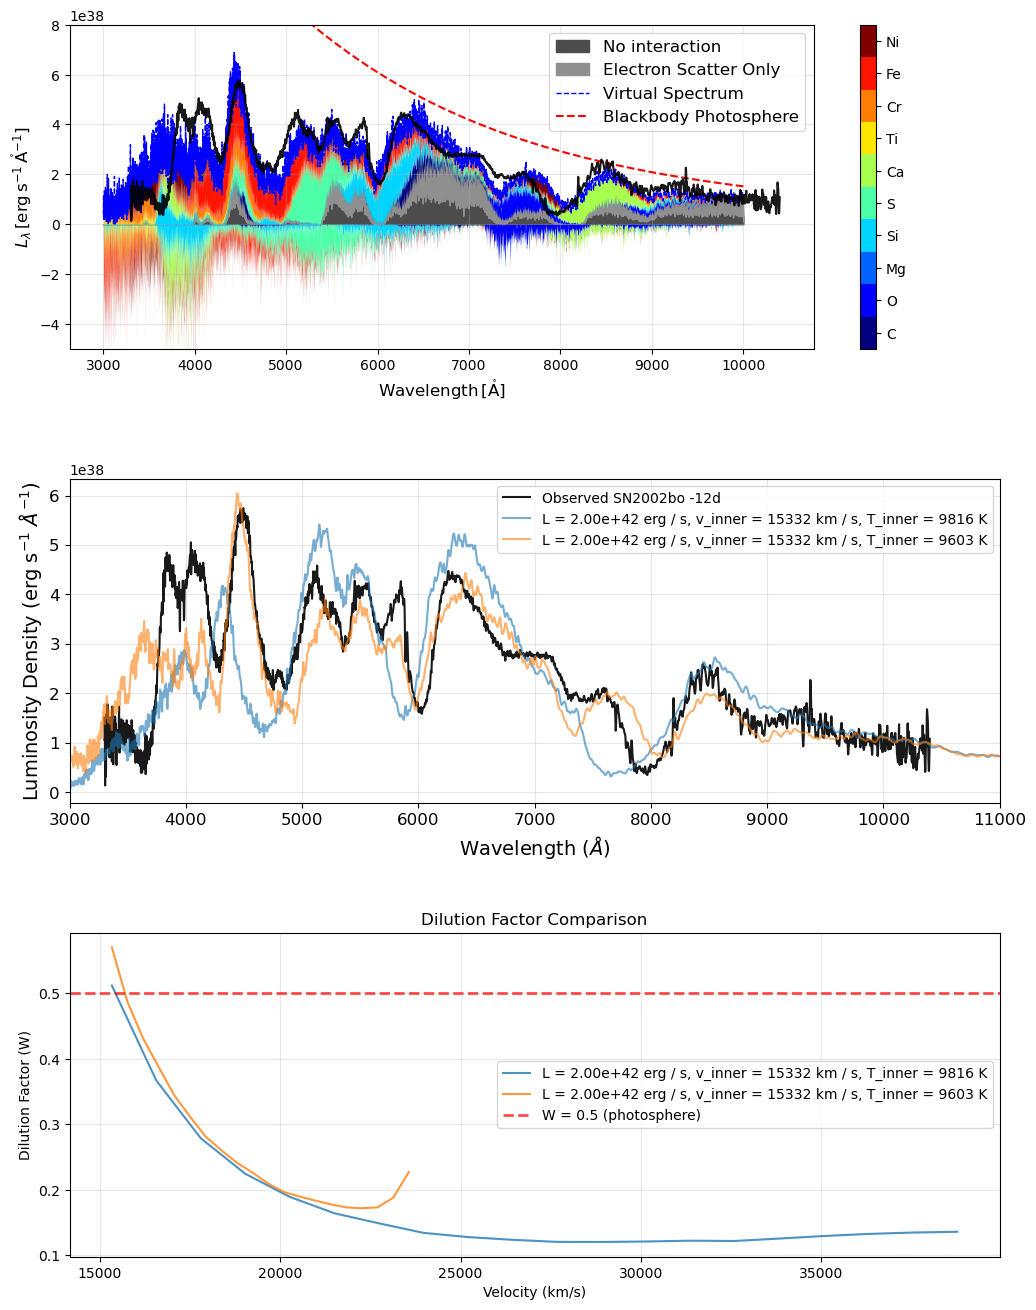

In [56]:
fig, axes = plt.subplots(3, 1, figsize=(12, 16))
plt.subplots_adjust(hspace=0.4)

# plot SDEC with the new v_inner
plot_SDEC_with_observations(sim_change_v_outer, spec_obs, ax=axes[0])
axes[0].set_ylim(-0.5e39, 0.8e39)

sim_s = [sim_change_rho_0_iter_2, sim_change_v_outer]
# compare the spectra with all previous simulations
plot_spectral_comparison(sim_s, spec_obs, ax=axes[1])

# plot the optical depth current simulation and the one the base config(see the notebook in the morning)
plot_dilution_factor(sim_s, ax=axes[2])


Notice that when changing v_outer_boundary, the dilution factor also deviates from the previous interaction, this shows that each parameter is not independent to each other, that's why we need detailed radaitive transfer simulations.  ????? --> T inner increase 

# Change elemental mass fraction 

TASK: 

**Identify an unmatched spectral feature as a starting point** as a start of changing other model parameters 

The Ca II near-infrared triplet (~8500 $\AA$) appears much broader in our synthetic spectrum than in observations. 

**Why is Ca II so broad?** The line-forming region is spatially extended, causing the line opacity to be spread across a wide velocity range.

**How can we reduce Ca II line opacity extent?** Options include:
- Steepen density gradient (higher exponent n) to concentrate Ca II in inner regions
- Modify Ca abundance distribution
- Adjust temperature structure through density changes


----

<>

LIV plots reveal that Ca II has an almost uniform distribution in velocity space for line interactions, unlike other ions that show more localized formation region near the photosphere.